In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import time
import math
from datetime import datetime

In [3]:
class NLinear(nn.Module):
    """
    Creates a multi-linear map of the form {M^{i..j}}_{k..l} with biases B^{i..j}.
    
    Methods:
    
    init(in_features:array, out_features:array, bias:bool): 
        in_features must be an integer array of length 3 (e.g. [3,512,512])
        out_features must be an integer array of length 3 (e.g. [3,256,256])
        Typically the first index is the color channel
        Input and output integer arrays must have the same length
        To map a tensor to a single number (e.g. yes/no classification) use a tensor like [1,1,1]
        
    """
    def __init__(self, 
                 in_features=[3,32,32], 
                 out_features=[3,32,32], 
                 bias=False,
                 gaussian_std=.1, 
                 noise_mean=1, 
                 noise_std=.1,
                 nonlocal_attenuation=False,
                 device="cpu"
                ): 
        super(NLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.gaussian_std = gaussian_std
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.nonlocal_attenuation=nonlocal_attenuation
        
        # Initialize the distance and Gaussian tensors
        dist, gaussian = self.get_distance_and_gaussian()
        self.dist = dist
        self.gaussian = gaussian
        self.dist.requires_grad = False
        self.gaussian.requires_grad = False
        
        M = torch.zeros(out_features + in_features, requires_grad=True, device=device)
        B = torch.zeros(out_features, requires_grad=True, device=device)
        
        # Initiate the bilinear transformation
        M, B = self.initialize_weights_and_bias(M, B)
        
        self.M = torch.nn.Parameter(M)
        if bias:
            self.B = torch.nn.Parameter(B)
        
        self = self.to(device)
 
    
    def get_distance_and_gaussian(self):        
        
        # Initialize with one color channel then repeat along all color_channels
        dist = torch.zeros([1,self.out_features[1], self.out_features[2], 1, self.in_features[1], self.in_features[2]], requires_grad=False)
        gaussian = torch.zeros([1,self.out_features[1], self.out_features[2], 1, self.in_features[1], self.in_features[2]], requires_grad=False)
        
        if len(self.out_features) > 1:
            mx = self.out_features[1]  #Dimension of target tensor in x direction
            my = self.out_features[2]  #Dimensions of input
            nx = self.in_features[1]
            ny = self.in_features[2]
            for i in range(nx):
                for j in range(ny):
                    for I in range(mx):
                        for J in range(my):
                            #Now define square distance tensor
                            m = np.min((mx, my))
                            n = np.min((nx, ny))
                            dist[0,I,J,0,i,j] = np.sqrt((I/m-i/n)**2+(J/m-j/n)**2)
                   
            gaussian = 1/(self.gaussian_std*np.sqrt(2*torch.pi)) * torch.exp(-dist**2/(2*self.gaussian_std**2))
            
        # Repeat along color channels
        c_in = self.in_features[0]
        c_out = self.out_features[0]
        dist = dist.repeat(c_out, 1, 1, c_in, 1, 1)
        gaussian = gaussian.repeat(c_out, 1, 1, c_in, 1, 1)

        return dist, gaussian
    
    
    def initialize_weights_and_bias(self, M, B):
        """
        Performs the standard uniform tensor initialization that torch does for Linear layers.
        
        Initializes the weights and bias just like torch: using uniform noise
        in the range -sqrt(1/in_features) to sqrt(1/in_features).
        """
        
        with torch.no_grad():
            k = 1/(np.prod(self.in_features))
            nn.init.uniform_(M, -np.sqrt(k), np.sqrt(k))
            #nn.init.uniform_(M, -k, k)
            #nn.init.normal_(M, mean=0, std=.001)
            #nn.init.normal_(M, mean=0, std=np.sqrt(k)/10)
            if self.bias:
                nn.init.uniform_(B, -np.sqrt(k), np.sqrt(k))
                
        return M, B
        
    def forward(self, x): 
        """
        Performs the forward pass tensor contraction:
        x^{ij} -> M^{ijk}_{lmn} x^{lmn} + B^{ijk}
        """

        if self.nonlocal_attenuation:
            x = torch.tensordot(x, self.M*self.gaussian, dims=((-3,-2,-1), (-3,-2,-1)))
        else:
            x = torch.tensordot(x, self.M, dims=((-3,-2,-1), (-3,-2,-1)))
        # Add in bias if chosen
        if self.bias:
            x += self.B
        
        return x

In [4]:
L0 = NLinear([3, 32, 32], [1, 16, 16])
print(L0.dist.shape)

torch.Size([1, 16, 16, 3, 32, 32])


In [5]:
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    nn.ConstantPad2d([2,2,2,2], 0.0)
])

# convert data to torch.FloatTensor
transform_3 = transforms.Compose([
    transforms.ToTensor(),
])

# convert data to torch.FloatTensor
transform_4 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()
])

# get the training datasets
train_data_1 = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader_1 = torch.utils.data.DataLoader(train_data_1, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

# get the training datasets
train_data_2 = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader_2 = torch.utils.data.DataLoader(train_data_2, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

# get the training datasets
train_data_3 = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform_3)

# prepare data loader
train_loader_3 = torch.utils.data.DataLoader(train_data_3, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

# get the training datasets
train_data_4 = datasets.CIFAR10(root='data', train=True,
                                   download=True, transform=transform_4)

# prepare data loader
train_loader_4 = torch.utils.data.DataLoader(train_data_4, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([1, 32, 32])


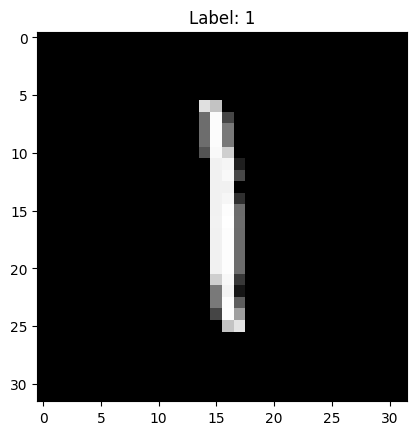

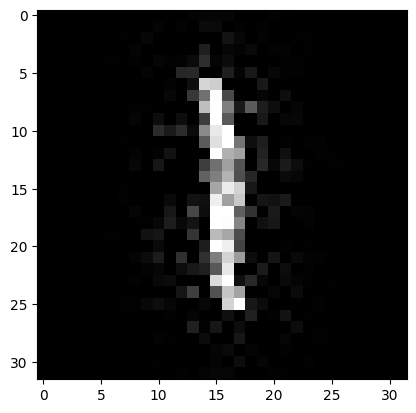

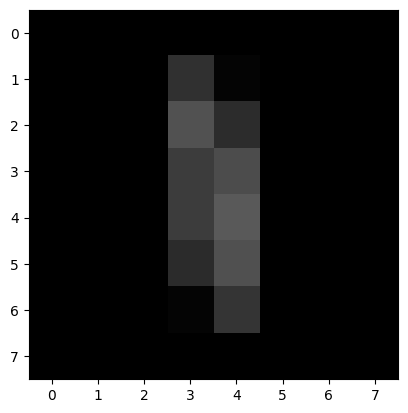

In [11]:
# obtain one batch of training images
rand_index = np.random.randint(0, len(train_data_1), 1)[0]

image = train_data_1[rand_index][0]
label = train_data_1[rand_index][1]
print(image.shape)

NLinear_Map = NLinear(in_features=[1, 32, 32], 
                      out_features=[1, 32, 32], 
                      nonlocal_attenuation=True, 
                      bias=False,
                      gaussian_std=.1, 
                      noise_mean=1.0,
                      noise_std=1
                     )
image2 = image+NLinear_Map(image.unsqueeze(0)).squeeze(0)
avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
image3 = avg_pool(avg_pool(image))

# get one image from the batch
img = torch.movedim(image, (0,1,2), (2,0,1)).squeeze()
img2 = torch.movedim(image2, (0,1,2), (2,0,1)).squeeze().detach()
img3 = torch.movedim(image3, (0,1,2), (2,0,1)).squeeze().detach()

plt.imshow(img, cmap="gray", vmin=0.0, vmax=1.0)
plt.title(f'Label: {label}')
plt.show()

plt.imshow(img2, cmap="gray", vmin=0.0, vmax=1.0)
plt.show()

plt.imshow(img3, cmap="gray", vmin=0.0, vmax=1.0)
plt.show()



In [20]:
class Linear_Discriminator(nn.Module):
    def __init__(self, color_channels=3, device="cpu", lamb=.1):
        super(Linear_Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(color_channels*32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
        
        self.activation = nn.ReLU()
        
        self = self.to(device)
        
    def forward(self, x):
        y = torch.flatten(x, start_dim=1)
        
        y = self.fc1(y)
        y = self.activation(y)
        
        y = self.fc2(y)
        y = self.activation(y)
        
        y = self.fc3(y)
        y = self.activation(y)
        
        y = self.fc4(y)
        y = y.unsqueeze(1).unsqueeze(1)
        
        return y

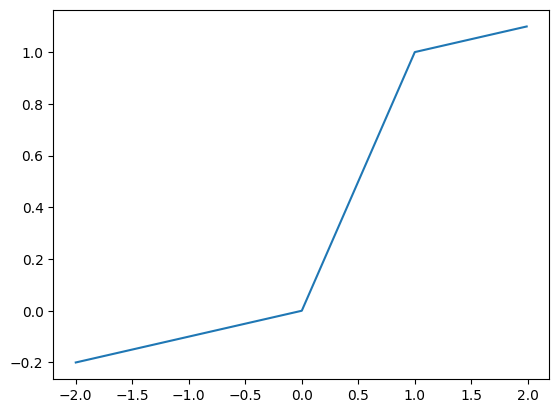

In [21]:
def soft_clip(x, mini=0.0, maxi=1,m=.1):
    """
    Inspired by leaky_relu, this non linear function takes data with mean close to zero 
    and applies the identity near the origin, but mildly supresses data outside of the interval [-1,1].
    
    It is useful for images where applying leaky_relu would favor positive values, potentially skewing the image.
    """
    y1 = m*(x-mini)+mini
    y2 = x
    y3 = m*(x-maxi)+maxi
    y = torch.where(x<mini, y1, torch.where(x>maxi, y3,y2))
    return y

x=torch.arange(-2,2,.01)
plt.plot(x, soft_clip(x))
plt.show()

In [35]:
class Generator(nn.Module):
    def __init__(self, train_loader, color_channels=1, device="cpu"):
        super(Generator, self).__init__()
        
        self.device = device
        c = color_channels
        self.color_channels = c
        
        self.NL1 = NLinear(in_features=[c, 4, 4], out_features=[c, 8, 8], nonlocal_attenuation=True)
        self.NL2 = NLinear(in_features=[c, 8, 8], out_features=[c, 16, 16], nonlocal_attenuation=True)
        self.NL3 = NLinear(in_features=[c, 16, 16], out_features=[c, 16, 16], nonlocal_attenuation=True)
        self.NL4 = NLinear(in_features=[c, 16, 16], out_features=[c, 32, 32], nonlocal_attenuation=True)
        
        self.activation = soft_clip
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.NL1(x)
        x = self.activation(x)
        
        x = self.NL2(x)
        x = self.activation(x)
        
        x = self.NL3(x)
        x = self.activation(x)
        
        x = self.NL4(x)
        x = self.activation(x)

        return image

In [25]:
g_test = Generator(train_loader_1, color_channels=1)

In [34]:
for module in g_test.modules():
    if type(module)==NLinear:
        print(module)

NLinear()
NLinear()
NLinear()
NLinear()


In [ ]:
# Fix the final resolution of the image (image is 2^Nx2^N)
N = 5

# number of color channels
color_channels = 1

# The dataset
train_loader = train_loader_2

# Noise character (0:white, 1:pink, 2:brownian)
noise_character = 1

# Learning Rate
gen_lr = .0001
disc_lr = .0001

# Betas for momentum in gradient decent
beta1 = .9
beta2 = .999

# number of epochs for training
n_epochs = 100

# number of images in each batch
batch_size = 128

# Overflow prefactor (determines how much we penalize bleeding outside of the range [0,1])
lamb=10

# Sets the frequency for discriminator training
# Setting it to an integer larger than one will help ensure the discriminator isn't overtrained
d_steps = 16

# Chooses device
# Note: experiencing bugs on mps. Reverting to cpu
def get_device():
    device = "cpu"
    # if torch.backends.mps.is_available():
    #     device = "mps"
    # elif torch.cuda.is_available():
    #     device = "cuda"
    
    return device

device = get_device()

In [ ]:
import torch.optim as optim

def create_optimizers(generator: nn.Module, discriminator: nn.Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=gen_lr, betas=[beta1, beta2])
    d_optimizer = optim.Adam(discriminator.parameters(), lr=disc_lr, betas=[beta1, beta2])
    
    return g_optimizer, d_optimizer

In [ ]:
def generator_loss(fake_logits, device="cpu", label_smoothing_factor=.9):
    """ Generator loss, takes the fake scores as inputs. """
    # TODO: implement the generator loss

    # This is the normal BCE loss
    labels = label_smoothing_factor * torch.ones(batch_size, device=device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(fake_logits.squeeze(), labels)
    
    return loss

def discriminator_loss(real_logits, fake_logits, device="cpu"):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    # TODO: implement the discriminator loss    

    # This is the normal BCE loss
    labels_real = torch.ones(batch_size, device=device)
    labels_fake = torch.zeros(batch_size, device=device)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(real_logits.squeeze(), labels_real) + criterion(fake_logits.squeeze(), labels_fake)

    return loss

def overflow_logits(x):
    """
    The logits to add to the loss term that penalizes the output image for bleeding outside of the range [0,1]
    This loss term is minimized separate from the generator and discriminator losses, 
    but trained with the generator in a generator step.
    """
    upper_overflow = (x-1)-torch.clip(x-1, max=0.0)
    lower_overflow = x-torch.clip(x, min=0.0)
    o_loss = torch.sum(upper_overflow**2+lower_overflow**2, dim=(-3,-2,-1), keepdim=True)
    
    return o_loss


In [ ]:
def generator_step(generator: Generator, 
                   discriminator:Discriminator, 
                   batch_size: int, 
                   haar_module: Haar, 
                   device="cpu",
                   overflow_penalty=False,
                   Lamb=.1
                  ) -> dict:
    """ 
    One training step of the generator. 
    Lamb1 is the lambda value of the overflow penalty
    Lamb2 is the lambda value of the nonlocal penalty
    """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    g_optimizer.zero_grad()
        
    # Generate random noise to feed into discrimnator
    z = haar_module.generate_noise(a=noise_character, batch_size=batch_size, color_channels=color_channels)
        
    # Create fake images
    fake_images = generator(z)
    
    # Feed fake images into discriminator and compute loss 
    # Note: generator is trying to trick discriminator, so it pretends these are real images
    fake_logits = discriminator(fake_images)
    o_logits = overflow_loss(fake_images)
    g_loss = generator_loss(fake_logits-Lamb*o_logits, label_smoothing_factor=0.9)
    #print("G Losses:",g_loss.squeeze().item(), generator_loss(fake_logits, device).squeeze().item())

    # Compute gradient and perform backward step
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss, 'overflow': torch.mean(o_logits)}


def discriminator_step(generator: Generator,
                       discriminator:Discriminator,
                       haar_module: Haar, 
                       real_images: torch.Tensor, 
                       device="cpu",
                      ) -> dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    d_optimizer.zero_grad()

    # First feed discriminator real images and compute logits
    real_images = real_images.to(device)
    real_logits = discriminator(real_images)
    
    true_batch_size = real_images.shape[0]

    # Next feed discriminator fake images from generator and compute logits
    z = haar_module.generate_noise(a=noise_character, batch_size=true_batch_size, color_channels=color_channels)
    fake_images = generator(z)
    fake_logits = discriminator(fake_images.detach())
    
    # Compute discriminator loss from real and fake images
    d_loss = discriminator_loss(real_logits, fake_logits, device)
    #print("D Losses:",d_loss.squeeze().item(), discriminator_loss(real_logits, fake_logits, device).squeeze().item())
    
    # Compute gradients and perform backward step
    d_loss.backward()
    d_optimizer.step()
    
    return {'loss': d_loss}

In [ ]:
print_every = 50

# Create generator, discriminator, and optimizers
generator = Generator(train_loader, training_haar_module, color_channels=color_channels, device=device)
discriminator = Linear_Discriminator(color_channels=color_channels, device=device)
#discriminator = Discriminator(color_channels=1, device=device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

In [ ]:
def display(image_tensor: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = image_tensor[idx, ...]
        img = torch.clip(img, 0.0, 1.0).detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        ax.imshow(img, vmin=0.0, vmax=1.0)
    plt.show()

In [ ]:
fixed_noise_tensor = training_haar_module.generate_noise(a=noise_character, 
                                                         batch_size=batch_size, 
                                                         color_channels=color_channels).to(device)

losses = []

print("============= Fixed Noise Tensor =============")
display(fixed_noise_tensor)
print("==========================")


for epoch in range(n_epochs):
    
    fresh_noise_tensor = training_haar_module.generate_noise(a=noise_character, 
                                                             batch_size=batch_size, 
                                                             color_channels=color_channels).to(device)
    
    for batch_i, images_and_labels in enumerate(train_loader):
        real_images = images_and_labels[0].to(device)
        
        # Some batches are smaller than batch_size so skipping these
        if real_images.shape[0] != batch_size:
            continue
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        
        g_loss = generator_step(generator=generator,
                                discriminator=discriminator,
                                batch_size=batch_size,
                                haar_module=training_haar_module,
                                device=device,
                                Lamb=lamb
                               )
        
        # Trains the discriminator every N steps
        if batch_i % d_steps == 0:
            d_loss = discriminator_step(generator=generator,
                                        discriminator=discriminator,
                                        haar_module=training_haar_module,
                                        real_images=real_images,
                                        device=device,
                                        Lamb=lamb
                                       )
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    generated_images1 = generator(fixed_noise_tensor)
    generated_images2 = generator(fresh_noise_tensor)
    print("Overflow Logits:", torch.mean(overflow_logits(generated_images1)).item())
    print("============= Fixed Noise Tensor =============")
    display(generated_images1)
    print("============= Fresh Noise Tensor =============")
    display(generated_images2)
    generator.train()

In [78]:
N=5
print(4/3*4**N -1/3)

1365.0
